# Week 7 - Building and Improving a Simple Language Model

Welcome back! In Week 6, we learned how to prepare textual data for training a language model. We generated input-target pairs using a DataLoader. This week, we'll build upon that foundation to implement and improve a simple neural network language model.

This notebook was created by Qumeng Sun and Lisa Beinborn. It adapts parts from Sebastian Raschka's notebooks accompanying his book "Build a Large Language Model (from Scratch)".


In [1]:
#!pip install 'torch>=2.0.1' 'jupyterlab>=4.0' 'tiktoken>=0.5.1' 'numpy>=1.25,<2.0'
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import tiktoken
from importlib.metadata import version
import math
import matplotlib.pyplot as plt


print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.3.1.post300
tiktoken version: 0.8.0


## 1. Review of data preparation

First, let's revisit how we prepared our data last week. We'll load the text data, tokenize it using the GPT-2 tokenizer, and prepare it for training.

In [3]:
from src.helper  import get_cleaned_spanish_text_as_string
text_path = "content/spa_wikipedia_2021_30K-sentences.txt"
path_to_save_folder= "model/train_data"

raw_text = get_cleaned_spanish_text_as_string(text_path)
#enc_text = tokenizer.encode(raw_text)

In [4]:
# Load the text data
raw_text = get_cleaned_spanish_text_as_string(text_path)

tokenizer = tiktoken.get_encoding("gpt2")

# Tokenize the text
token_ids = tokenizer.encode(raw_text)

print("Total number of tokens:", len(token_ids))
print("First 10 tokens:", token_ids[:10])

Total number of tokens: 1221649
First 10 tokens: [1105, 390, 450, 22379, 390, 8235, 1658, 555, 64, 719]


## 2. Preparing dataset and dataloader

We'll use the same `GPTDataset` class and `create_dataloader` function that we defined in Week 6 to generate input-target pairs where the target is the input sequence shifted by one token to the right.

In [5]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from src.dataset import GPTDataset
from src.dataset import create_dataloader


## 3. Training and evaluating a base model

We'll start by defining and training a simplistic language model to understand the process.

### 3.1. Defining the model

Our base model will consist of:
- **Token Embeddings**: Convert token IDs to dense vectors.
- **Positional Embeddings**: Incorporate positional information.
- **Linear Layer**: Predict the next token in the sequence.

We'll set an appropriate `context_length` during initialization.

In [10]:
from src.model import SimpleLanguageModel

### 3.2. Setting up training parameters

We'll initialize our model with an appropriate `context_length` and prepare for training.

Check the torch documentation for the description of [CrossEntropyLoss](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html#CrossEntropyLoss) and try to understand what it means that it "is equivalent to applying LogSoftmax on an input, followed by NLLLoss."

Check the documentation for the [AdamOptimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) and make sure you understand the role of the lr parameter. 

In [11]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Parameters
batch_size = 128
context_length = 32  # Context size for training
vocab_size = tokenizer.n_vocab
embedding_dim = 128

# Create the DataLoader
train_dataloader, dev_dataloader, test_dataloader = create_dataloader(
    raw_text, batch_size=batch_size, 
    context_length=context_length, shuffle=True
)

# Initialize the model
model = SimpleLanguageModel(vocab_size, embedding_dim, context_length).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop parameters
num_epochs = 1

data_loader = train_dataloader
train_run_label = "temp"
print_every = 1

Using device: cuda


### 3.3. Training the model

Let's train a very simple model and monitor the loss. This will take a while. 
Make sure you understand every step of the code at least conceptually and consult the pytorch documentation. If the training process takes too long, test it with a smaller portion of the dataset and/or fewer epochs first. 

In [12]:

# train(model,num_epochs,optimizer,criterion,data_loader,path_to_save_folder,train_run_label)
#return (all_losses,train_losses,perplexities)
from src.train import train
(all_losses,train_losses,perplexities) = train(model,num_epochs,optimizer,criterion,data_loader,path_to_save_folder,
                                               train_run_label,vocab_size,device,print_every)

Epoch [1/1], Step [0/7635], Loss: 11.1762
Epoch [1/1], Step [1/7635], Loss: 11.1383
Epoch [1/1], Step [2/7635], Loss: 11.0960
Epoch [1/1], Step [3/7635], Loss: 11.0432
Epoch [1/1], Step [4/7635], Loss: 10.9952
Epoch [1/1], Step [5/7635], Loss: 10.9477
Epoch [1/1], Step [6/7635], Loss: 10.9121
Epoch [1/1], Step [7/7635], Loss: 10.8678
Epoch [1/1], Step [8/7635], Loss: 10.8273
Epoch [1/1], Step [9/7635], Loss: 10.7842
Epoch [1/1], Step [10/7635], Loss: 10.7331
Epoch [1/1], Step [11/7635], Loss: 10.6953
Epoch [1/1], Step [12/7635], Loss: 10.6840
Epoch [1/1], Step [13/7635], Loss: 10.5990
Epoch [1/1], Step [14/7635], Loss: 10.5769
Epoch [1/1], Step [15/7635], Loss: 10.5346
Epoch [1/1], Step [16/7635], Loss: 10.5055
Epoch [1/1], Step [17/7635], Loss: 10.4527
Epoch [1/1], Step [18/7635], Loss: 10.4370
Epoch [1/1], Step [19/7635], Loss: 10.3722
Epoch [1/1], Step [20/7635], Loss: 10.2893
Epoch [1/1], Step [21/7635], Loss: 10.2900
Epoch [1/1], Step [22/7635], Loss: 10.2307
Epoch [1/1], Step [23

In [9]:
#To read old results 
#read_list_from_file(label,path_to_save_folder)
from src.helper import read_list_from_file
#train_losses=read_list_from_file("onlyLossesUntil3593",path_to_save_folder)
#perplexities= read_list_from_file("normal_model_perplexities",path_to_save_folder)

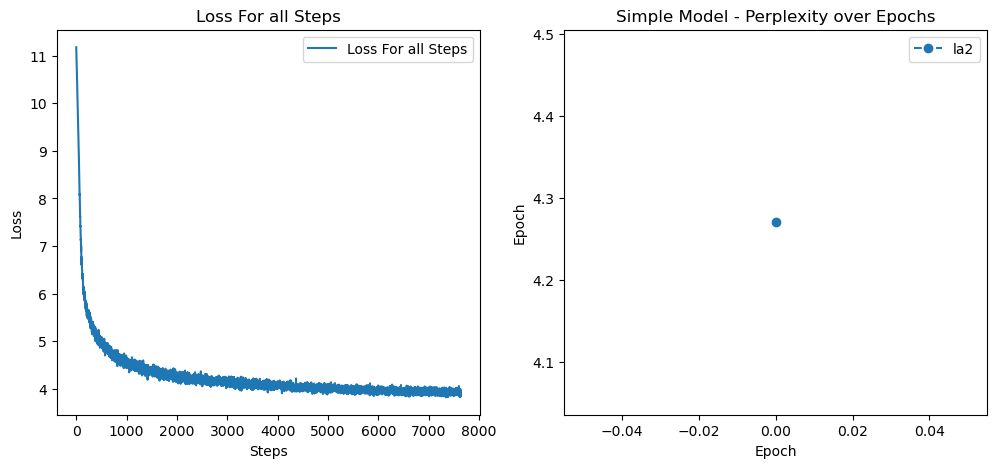

In [21]:
from src.plot import plot_two
plot_two(all_losses,"Loss For all Steps",train_losses,"la2",axLabel1=("Steps","Loss"))

### 3.4. Evaluating the model

Now, we'll compute the perplexity of our simplest model on the development set.

In [25]:
from src.train import evaluate
perplexity_simple = evaluate(model, dev_dataloader,criterion,device,vocab_size)
print(f"Perplexity of base model: {perplexity_simple:.2f}")

Perplexity of base model: 50.65


## 4. Training with dropout

To prevent overfitting and improve generalization, we'll test dropout as a regularization strategy. 

### 4.1. Adding dropout

We'll modify our model to include a dropout layer.

In [26]:
from src.model import RegularizedLanguageModel

### 4.2. Retraining the model with dropout

We'll re-initialize the model and optimizer, then retrain.

In [15]:
# train(model,num_epochs,optimizer,criterion,data_loader,path_to_save_folder,train_run_label)
#return (all_losses,train_losses,perplexities)
from src.train import train
num_epochs = 1

model = RegularizedLanguageModel(vocab_size, embedding_dim, context_length, dropout=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
data_loader = train_dataloader
train_run_label = "1_droupot_model"
print_every = 1



(all_losses,train_losses,perplexities) = train(model=model,num_epochs=num_epochs,optimizer=optimizer,criterion=criterion,data_loader=data_loader,path_to_save_folder=path_to_save_folder,
                                               train_run_label=train_run_label,vocab_size=vocab_size,device=device,print_every=print_every)

Epoch [1/1], Step [0/7635], Loss: 11.2415
Epoch [1/1], Step [1/7635], Loss: 11.2124
Epoch [1/1], Step [2/7635], Loss: 11.1550
Epoch [1/1], Step [3/7635], Loss: 11.1095
Epoch [1/1], Step [4/7635], Loss: 11.0850
Epoch [1/1], Step [5/7635], Loss: 11.0378
Epoch [1/1], Step [6/7635], Loss: 11.0372
Epoch [1/1], Step [7/7635], Loss: 10.9615
Epoch [1/1], Step [8/7635], Loss: 10.8956
Epoch [1/1], Step [9/7635], Loss: 10.8735
Epoch [1/1], Step [10/7635], Loss: 10.7948
Epoch [1/1], Step [11/7635], Loss: 10.7650
Epoch [1/1], Step [12/7635], Loss: 10.7319
Epoch [1/1], Step [13/7635], Loss: 10.7051
Epoch [1/1], Step [14/7635], Loss: 10.6483
Epoch [1/1], Step [15/7635], Loss: 10.5948
Epoch [1/1], Step [16/7635], Loss: 10.5629
Epoch [1/1], Step [17/7635], Loss: 10.5020
Epoch [1/1], Step [18/7635], Loss: 10.4640
Epoch [1/1], Step [19/7635], Loss: 10.4379
Epoch [1/1], Step [20/7635], Loss: 10.4157
Epoch [1/1], Step [21/7635], Loss: 10.3223
Epoch [1/1], Step [22/7635], Loss: 10.3253
Epoch [1/1], Step [23

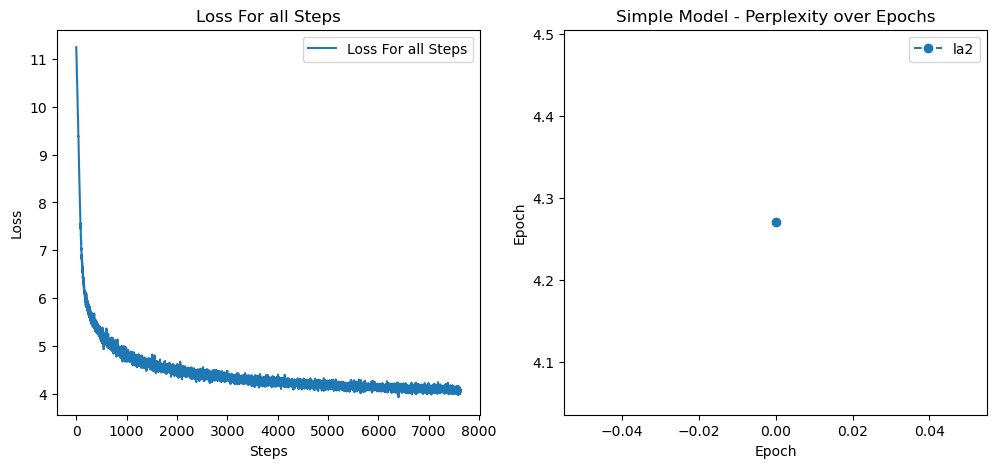

In [29]:
#read_list_from_file(label,path_to_save_folder)
from src.helper import read_list_from_file
all_losses = read_list_from_file("0_final/dropout/1_droupot_model_step_losses",path_to_save_folder)


from src.plot import plot_two
plot_two(all_losses,"Loss For all Steps",train_losses,"la2",axLabel1=("Steps","Loss"))

### 4.3. Evaluating the dropout model

Now, we'll compute the perplexity of our modified model.

In [32]:
from src.train import evaluate
path_to_model = path_to_save_folder +"/"+"0_final/dropout/1_droupot_model_model"
model.load_state_dict(torch.load(path_to_model, weights_only=True))

perplexity_regularized = evaluate(model, dev_dataloader,criterion,device,vocab_size)
print(f"Regularized Model Perplexity: {perplexity_regularized:.2f}")

Regularized Model Perplexity: 52.23


## 5. Improving the Model

Now, try to further improve the model. For example, you could:
- Increase the model depth.
- Increase the embedding dimension.
- Introduce non-linear activation functions.
- Adjust the `context_length`.
- Adjust the parameters of the optimizer. 

## 6. Generating text 


In [41]:
#def generate_text(model, tokenizer, start_text, context_length=15, temperature=1.0):
from src.model import generate_text


start_text = "Esto es "

for x in range(10):
    generated_text = generate_text(model, tokenizer, start_text, device=device, context_length=20)
    print(generated_text)

start_text = "A los artistas se les"
print("\n\nNew Beginning")

for x in range(10):
    generated_text = generate_text(model, tokenizer, start_text, device=device, context_length=20)
    print(generated_text)

Esto es  su papelisia de mayo con lo largo muchas anunci
Esto es   PNR. En febre O principal almas positivas que Pner
Esto es  Herb Deanroteen ser organizó su últimismo se constit
Esto es izó en el momento de Novela decepoca. Adaptó a
Esto es  tensos Mark Jenkins era su rojo ubicidad de las actuación
Esto es izando las puede soldado no a las acces enl I
Esto es  mero quéndiceímite de 10 a cocina en la e
Esto es . Energicionales la cualquir Talces es Nuest
Esto es  propato sobre toda. Hay ense mismo era un hogar
Esto es  en voluntar por ordencias ese encuideradas a rec


New Beginning
A los artistas se les infra en el compromiso a 000 como un curios del
A los artistas se les hablico El material había sido que pá
A los artistas se les pastidad ausión que se vida tarde fí
A los artistas se lesiones puesta y la Facultades para propiedades finan
A los artistas se les tien lomo matrimon sufrir los pasarici
A los artistas se les élbumes de mano respalda con los cerr
A los artistas se les infa